<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: k-Means Clustering](05.11-K-Means.ipynb) | [Contents](Index.ipynb) | [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In Depth: Gaussian Mixture Models

*k*-means的非機率本質，以及它所使用的簡單想法，從群組中心的距離來指定群組的成員關係，將導致在許多真實世界情況下不好的效能。

將檢視高斯混合模型，它可以被看成是隱藏在k-平均背後的概念的延伸，但是可以成為比簡單的集群評估更強力的工具。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 使用GMM的動機: k-平均法的弱法

In [3]:
# 產生一些資料
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] 

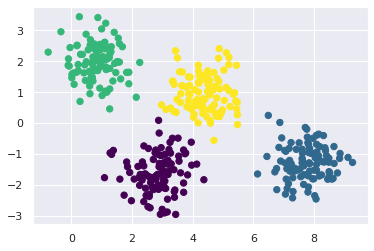

In [4]:
# 繪出k-means的資料標籤
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

中間兩組會有的點看起來有點重疊，因此K-means無法精確去分類是屬於哪一組，對於機率或是群組設定的不確定性沒有一個基本的衡量方式。對於此點，必須要思考關於模型的一般化。

其中一個關於K-means模型的思考方向就是在每一群的中心放置一個圓(或如果是在高維度中，是一個超球面)，加上一個由此群中最遠的那一點所界定的半徑。此半徑在訓練資料集中作為一個嚴格斷面:任一個在此圓之外的點都不被認為是此群的一員。

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # 繪出輸入的資料
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # 繪出平均模型的表示方法
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

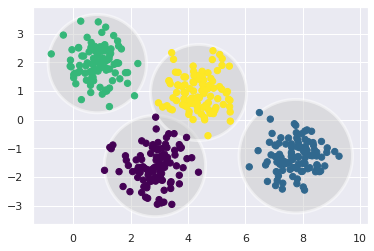

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

對k-means而言，這些集群模型必須是圓形的: k-means沒有內建的方法用來處理橢圓的群。所以如果拿到同樣的資料並把它進行轉換，則此集群的設定就會被搞糊塗了。

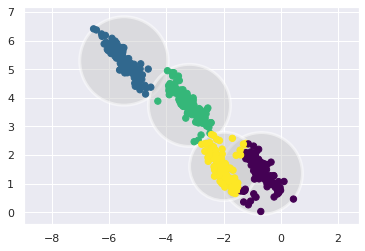

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

透過眼睛，可以辨識出這些轉換過的群不是正圓形，因此用正圓形的群組去規範就不適合。
k-means不適合去應付此種情境，但會試著去把這些資料擬合到4個正圓形的集群中，這樣會造成群的指定在重疊之處被混在一起:特別是在此圖的右下角處。

k-means有兩個缺點:缺乏在群組形狀上的彈性，而且缺乏機率集群的指定(有許多特別是低維度的資料集，並沒有辦法像我們期待的執行的那麼好)。

解決方法:在集群設定時，藉由比較每一資料點到群中心處來衡量不確定性，而不聚焦在距離最近，可能也會想要允許此群的邊界可以是橢圓形而不一定要是正圓形。即為高斯混合模型可做到的事情。

## 高斯混合模型(Gaussian Mixture Models)

高斯混合模型嘗試去尋找一個多維度高斯機率分布的混合體，讓它可以最佳化形塑任一輸入之資料集。在一個簡單的例子中，GMM可以被使用在像是k-means一樣同樣的方法以找出群組。

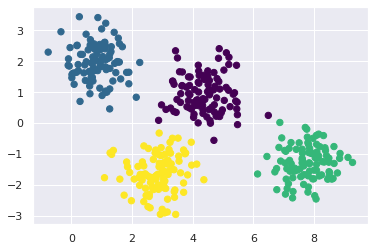

In [9]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

但因為GMM的內部包含了機率模型，它也可能被用來找出指定群組的機率-在Scikit-Learn中使用``predict_proba``方法來執行。此傳回的值是一個大小為``[n_samples, n_clusters]``的矩陣，它量測了任一個資料點屬於某一給定之群組的機率:

In [10]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.537 0.    0.463 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


可以使用每一個點的大小比例標示出其預測的確定性來視覺化出此種不確定性值。

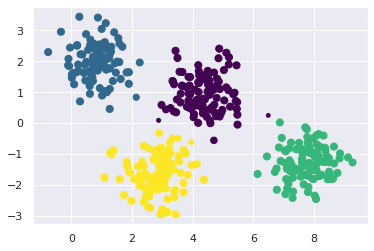

In [11]:
size = 50 * probs.max(1) ** 2  # 平方強調差值
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

隱藏在背後的，高斯混合模型非常類似於k-means:它使用最大期望算法方式，而其量化的行為如下:

1. 選擇一開始猜測的位置和形狀
2. 重複直到收斂:
   1. *E-step*:對於每一個點，找出權重以用來編碼在每一個群之中為成員的機率
   2. *M-step*:對於每一個群，以所有資料點為基礎，利用這些權重更新它的位置、常規化以及形狀

執行後的結果，每一個群所結合的就不只是一個嚴格的球面，而是一個平滑的高斯模型。正如在k-means中的最大期望算法方式，此演算法有時候會失去整體的最佳化，但在實務上有多個隨機模型可以使用於此。

In [20]:
# 此函式藉由畫出以gmm輸出為基的橢圓，幫助我們去視覺化GMM集群的形狀
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """給一個位置和covariance，即可畫出一個橢圓"""
    ax = ax or plt.gca()
    
    # 把covariance轉換到主軸
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 畫出橢圓
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
  

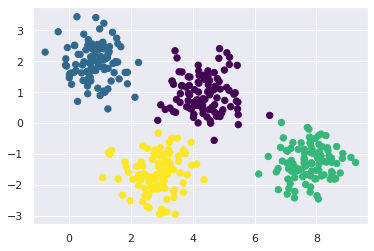

In [21]:
# 4 component GMM處理資料
gmm = mixture.GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

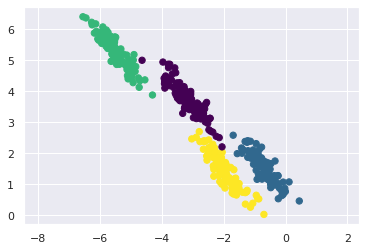

In [22]:
# 也可使用GMM的方法去擬合延展過的資料集，設定covariance_type=full
# 此模型可以擬合到非常延展拉伸的群上
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

GMM可以解決之前在k-means所遇到的2個主要實務上的問題

### 選用covariance類型

``covariance_type``控制每一個集群形狀的自由度，在面對任何一個給定的問題時，基本上要小心設定。
預設是``covariance_type="diag"``，意思是群組的大小在每一個維度可以被獨立的設定，則結果的橢圓形會被限制在對齊的軸線上。

``covariance_type="spherical"``限制讓群組的形狀在所有的維度中都是相同的，此結果的群組和k-means有類似的特性，然而它們並不完全等價。

``covariance_type="full"``讓每一個群組可以在任意方向被形塑成橢圓形，但會花非常多計算成本。

![(Covariance Type)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.12-covariance-type.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Covariance-Type)

## 把GMM當作是密度計算(Density Estimation)

雖然GMM經常被歸類到集群演算法，然而它基本上是一個用來做*密度計算*的演算法。也就是說，GMM擬合的結果在技術上不是一個集群模型，而是一個用來描述資料分佈的生成機率模型(generative probabilistic model)。

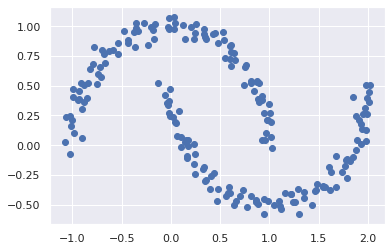

In [23]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

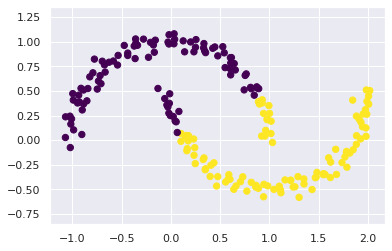

In [24]:
# 2-component GMM當作是集群模型去擬合此資料，結果並不會特別有用處
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

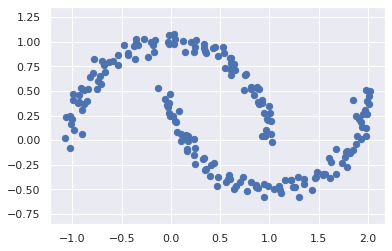

In [25]:
# 如果使用更多的component來取代，並忽略群組的標籤，則可以找到一個更接近輸入資料的擬合結果
gmm16 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

在此使用16個高斯的混合不是為了要找出資料分隔用的群組，但是卻形塑了此輸入資料的整體*分佈狀態*。這是一個分佈的生成式模型，代表的意義是GMM給我們一個產生和輸入的資料相似的，新的隨機資料分佈步驟。

GMM可以很方便的當作是一個具有彈性的，用來塑模任一多維度的資料分佈的方法。

### 需要多少個component?

GMM實際上是一個生成模型，給一個資料集，它給我們一個自然的方法決定元件的最佳數目。一個生成模型是承襲自資料集的機率分佈，因此可以簡單的評估在模型之下資料的*可能性*，使用交叉驗證以避免過度擬合。

另一個修正過度擬合的方法是使用一些分析的規範，如:AIC, BIC去調整模型的可能性。Scikit-Learn的GMM評估器實際上包含了內建的模型可以計算此兩種，所以就可以非常簡單的操作。

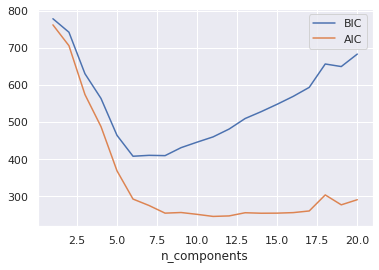

In [29]:
# 使用AIC和BIC當作是GMM元件數目函數的情形
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

想知道使用的近似值為何，最佳的群組數目是AIC或BIC最小化值。從AIC中可以得知我們選用了16個components可能太多了，大約是8到12個components會是比較好的選擇。

留意一點:component數目的選擇衡量了GMM當作是一個密度評估器表現的好壞，而不是當作是一個集群演算法的好壞。建議把GMM想成是密度評估器，只有確實是在簡單的資料集中才把它當作是集群方法使用。

## 範例: 使用GMM來產生新資料

從之前使用過的標準數字元素材中，產生新的手寫數字元

In [30]:
# 載入數字元
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

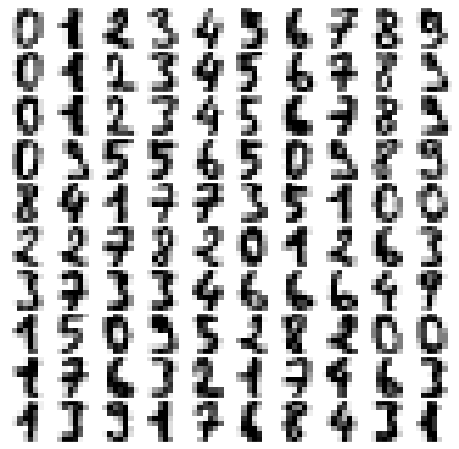

In [31]:
# 匯出前100個資料
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

在64個維度中有將近1800個數字元，而可以在其中建立一個GMM，以產生更多資料。在高維度資料中，GMM不容易收斂，因此要先做一個可逆的降維，在此用PCA，要求在投影的資料中保留99%的變異量:

In [32]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

結果變成41維度，而資料沒有任何損失。再去使用AIC去取得需使用的GMM component數目之估計。

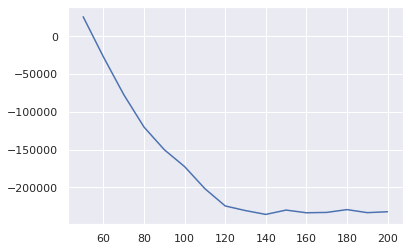

In [33]:
n_components = np.arange(50, 210, 10)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

大約在110個component時會最小化AIC。

此結果從任一部分看起來都像是從資料集中找出來的數字元。

這裡的操作:給一個手寫數字元的樣本，透過從資料產生的全新數字元樣本，建模此資料的分布:這些是沒有個別出現在原始資料集中的"手寫數字元"，而不是當作一個混合模型去擷取輸入資料的一般化特徵。